In [1]:

import anndata as ad
import pandas as pd
from scipy.sparse import csr_matrix, vstack, hstack, coo_matrix
import numpy as np
from pathlib import Path
import scanpy as sc
import scrublet as scr


In [17]:
obs = pd.read_csv("data/cell_barcode_labels.csv", index_col=0)


In [3]:


def read_csv_to_coo_matrix(file_path, filter_features=None):

    if filter_features is None:
        targets_set = set()
        process_all = True
    else:
        targets_set = set(filter_features)
        process_all = False


    # Initialize lists to hold the COO data
    row_indices = []
    col_indices = []
    data = []
    ids = []
    keep_rows = []

    row_idx = 0

    with open(file_path, 'r') as file:
        print(f"opened {file_path}")
        # Read the header line
        header = file.readline()
        # Read the rest of the lines
        for frow_idx, line in enumerate(file):
            # Get the first entry by reading up to the first comma
            first_entry = line.split(',', 1)[0]
            # Check if the first entry is a target
            if first_entry in targets_set or process_all:
                keep_rows.append(frow_idx)
                # read the entire line
                id,*cnts = line.strip().split(',')
                ids.append(id)
                # Split the line into values and convert them to 8-bit integers
                values = np.array(cnts, dtype=np.uint8)
                
                # Get the non-zero indices and corresponding values
                non_zero_indices = np.nonzero(values)[0]
                non_zero_values = values[non_zero_indices]
                
                # Append the data to the COO format lists
                row_indices.extend([row_idx] * len(non_zero_indices))
                col_indices.extend(non_zero_indices)
                data.extend(non_zero_values)
                # incriment the row index
                row_idx += 1


    # Create the COO matrix
    num_rows = row_idx
    header = header.strip().split(',')
    # remove "genes" from header
    header = header[1:]
    num_cols = len(header)
    matrix_coo = coo_matrix((data, (row_indices, col_indices)), shape=(num_rows, num_cols), dtype=np.uint8)
    
    return matrix_coo, header, ids, keep_rows





def make_anndata_from_bigcsv(big_csv_file_path, filter_features=None, meta_obs=None, meta_var=None):
    """ create an anndata object from a large csv file """

    # Call the function with the file path
    sparse_matrix_coo, cols, idxs, kept = read_csv_to_coo_matrix(big_csv_file_path, filter_features=filter_features)

    # Convert the COO matrix to a CSR matrix
    if meta_obs is None:
        # obs_ = obs_.merge(meta_obs, left_index=True, right_index=True)
        meta_obs = pd.DataFrame(cols, index=cols, columns=['cell_ids'])
    else:
        meta_obs['cell_ids'] = cols

    if meta_var is None:
        # var_ = var_.merge(meta_var, left_index=True, right_index=True)
        meta_var = pd.DataFrame({'gene_ids':idxs, 'big_idx':kept}, index=idxs)
    else:
        meta_var['gene_ids'] = idxs
        meta_var['big_idx'] = kept


    adat_out = ad.AnnData(X=sparse_matrix_coo.transpose().tocsr(), obs=meta_obs, var=meta_var)
    return adat_out


In [4]:

big_csv_file_path = "./data/brain_atlas_full_counts_table.csv"
# Open the large CSV file
small_csv_file_path = './data/counts_3k.csv'


ad4 = make_anndata_from_bigcsv(big_csv_file_path, meta_obs=obs, meta_var=None)


opened ./data/brain_atlas_full_counts_table.csv


In [2]:
# ad4.write_h5ad("./data/ad4.h5ad")

adata = ad.read_h5ad("./data/ad4.h5ad")

In [3]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")  # "MT-" for human, "Mt-" for mouse
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))




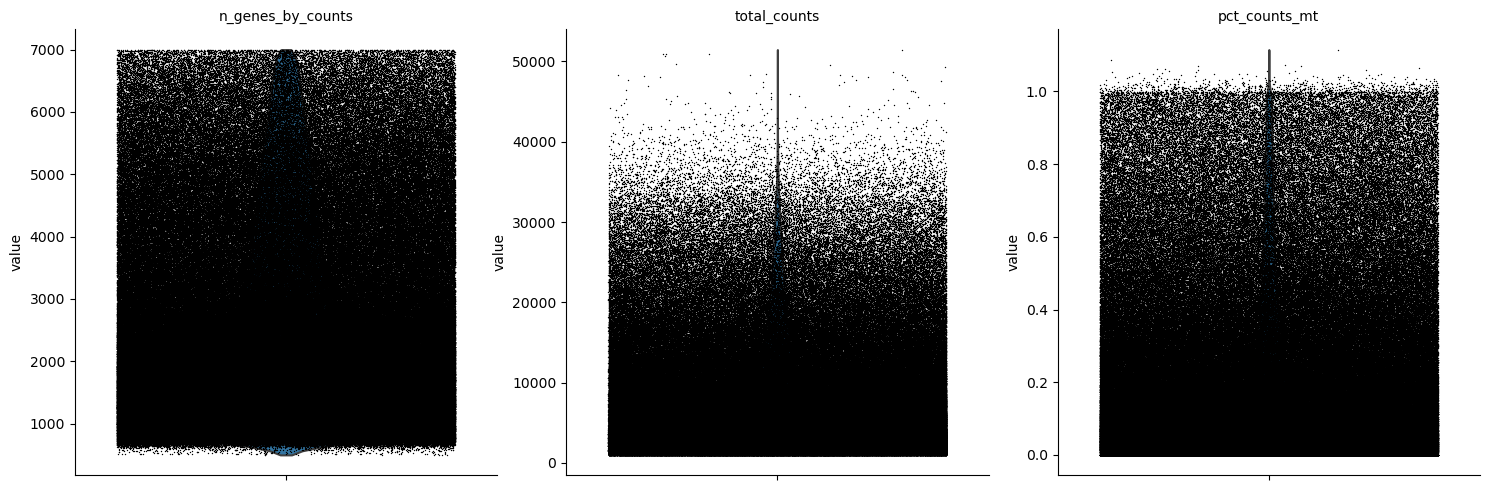

In [9]:


sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True, save="_qc_violin.png")


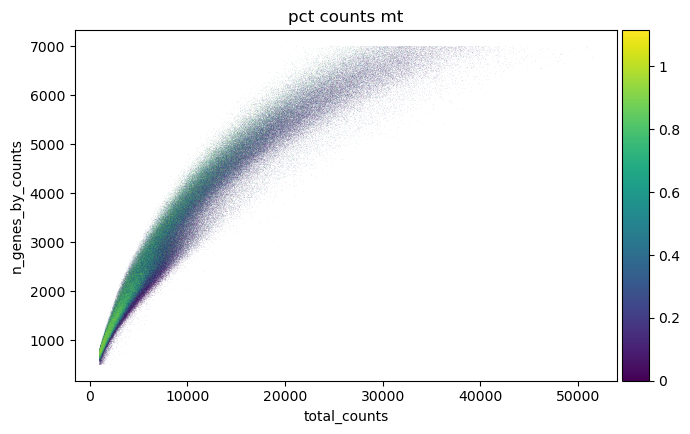

In [10]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [11]:
# sc.pp.filter_cells(adata, min_genes=100)
# sc.pp.filter_genes(adata, min_cells=3)

### Doublet detection

As a next step, we run a doublet detection algorithm. Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps. Scanpy contains the doublet detection method Scrublet {cite}`Wolock2019`. Scrublet predicts cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets. {func}`scanpy.external.pp.scrublet` adds `doublet_score` and `predicted_doublet` to `.obs`. One can now either filter directly on `predicted_doublet` or use the `doublet_score` later during clustering to filter clusters with high doublet scores. 

In [12]:
sc.external.pp.scrublet(adata, batch_key="sample")

/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 15.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 20.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 40.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 11.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 46.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 15.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 14.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 16.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 32.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 25.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 14.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 50.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 30.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 33.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 49.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.40
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 47.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 20.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 21.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 42.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 8.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 23.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 41.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 13.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 27.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 15.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 19.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.5%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 51.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.38
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 49.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 42.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 20.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.38
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 45.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 14.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 49.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 14.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.36
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 48.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.6%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 10.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.5%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 23.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.38
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 40.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.5%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 19.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 29.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 36.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 22.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 35.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 15.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.40
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 49.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 28.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 38.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 14.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 33.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 27.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 20.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 45.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 36.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 14.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.36
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 44.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 26.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 41.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 46.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 40.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 32.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 34.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.38
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 39.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 38.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 39.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 16.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 36.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 35.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 25.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 22.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 32.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 37.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 10.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.40
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 37.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 40.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 27.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.19
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 39.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 43.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 38.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 31.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 26.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 35.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 33.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 12.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 41.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 23.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 25.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 13.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 15.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.36
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 36.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 25.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 39.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 23.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.7%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 23.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 23.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 15.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.6%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 35.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 20.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 11.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 28.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 26.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 34.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.39
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 24.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 36.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 12.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.38
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 42.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 22.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.23
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 43.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 19.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 45.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.31
Detected doublet rate = 1.2%
Estimated detectable doublet fraction = 14.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.7%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 34.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 47.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 45.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 17.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 42.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 31.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 16.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.40
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 18.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.7%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 20.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.8%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 43.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.37
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 32.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.7%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.38
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 38.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 32.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 18.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 9.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.31
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 44.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 19.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 12.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 9.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.6%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 31.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 18.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 34.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 13.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 29.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%


## Normalization

The next preprocessing step is normalization. A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via `target_sum` in `pp.normalize_total`. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [13]:
# Saving count data
adata.layers["counts"] = adata.X.copy()


In [14]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data:

sc.pp.log1p(adata)

In [24]:
obs.head()

,seurat_clusters,cell_type,sample
cells,,,
GGCCTAATCGATTTAG-1_1,11,Mature neurons,KEN-1070-ARC
TAGTAACGTAGTCAAT-1_1,5,Mature neurons,KEN-1070-ARC
GAAAGCCAGCAGCTCA-1_1,2,Oligodendrocytes,KEN-1070-ARC
ACTCACCTCCTCCCTC-1_1,5,Mature neurons,KEN-1070-ARC
CTTCATCCAATCGCAC-1_1,11,Mature neurons,KEN-1070-ARC


In [22]:


clean_samples_path = Path.cwd() / "data" / "Model Combinations - clean_samples_138.csv"
clean_samples = pd.read_csv(clean_samples_path)
clean_samples.head()



,sample,batch
0,KEN-1070-ARC,batch1
1,KEN-1092-ARC,batch1
2,KEN-1095-ARC,batch1
3,KEN-1127-ARC,batch1
4,KEN-1132-ARC,batch1


In [27]:
adata

AnnData object with n_obs × n_vars = 713626 × 36601
    obs: 'seurat_clusters', 'cell_type', 'sample', 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', 'batch'
    var: 'gene_ids', 'big_idx', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet', 'log1p'
    layers: 'counts'

In [26]:

batch_mapper = dict(zip(clean_samples["sample"], clean_samples["batch"]))
adata.obs["batch"] = adata.obs["sample"].map(batch_mapper)

## Feature selection

As a next step, we want to reduce the dimensionality of the dataset and only include the most informative genes. This step is commonly known as feature selection. The scanpy function `pp.highly_variable_genes` annotates highly variable genes by reproducing the implementations of Seurat {cite}`Satija2015`, Cell Ranger {cite}`Zheng2017`, and Seurat v3 {cite}`stuart2019comprehensive` depending on the chosen `flavor`. 

In [28]:
# sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="sample")
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=3000,
    layer="counts",
    batch_key="batch",
    subset=True,
)


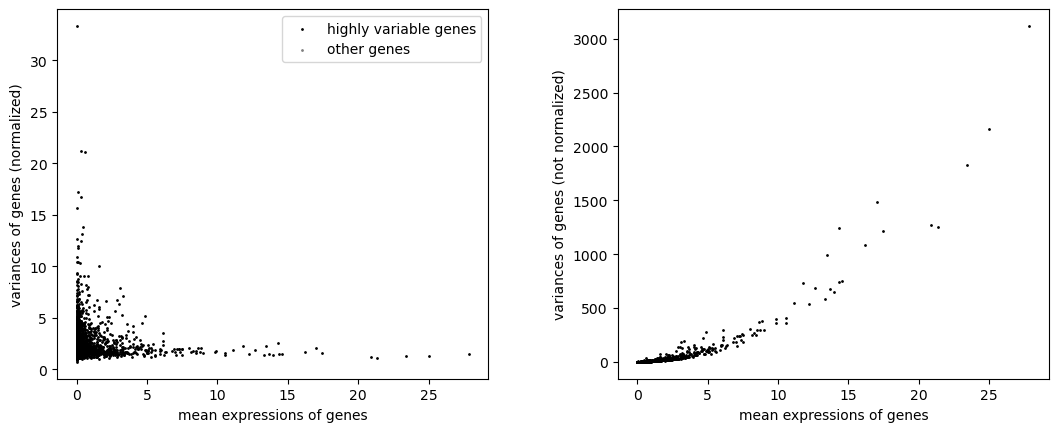

In [29]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [30]:
sc.tl.pca(adata)

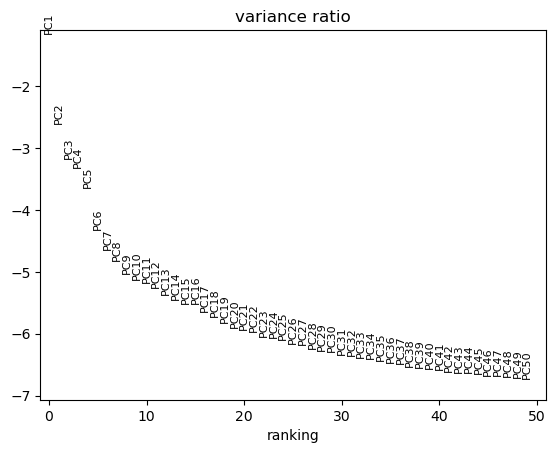

In [31]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [32]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/si

## Clustering

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) {cite}`traag2019louvain`. Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


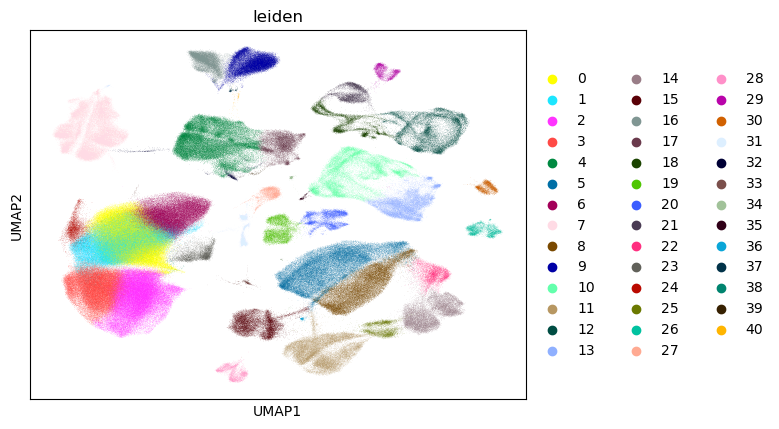

In [33]:

sc.tl.leiden(adata)
sc.pl.umap(adata, color=["leiden"])


## Re-assess quality control and cell filtering 

As indicated before, we will now re-assess our filtering strategy by visualizing different QC metrics using UMAP. 

In [34]:
adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype("category")


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


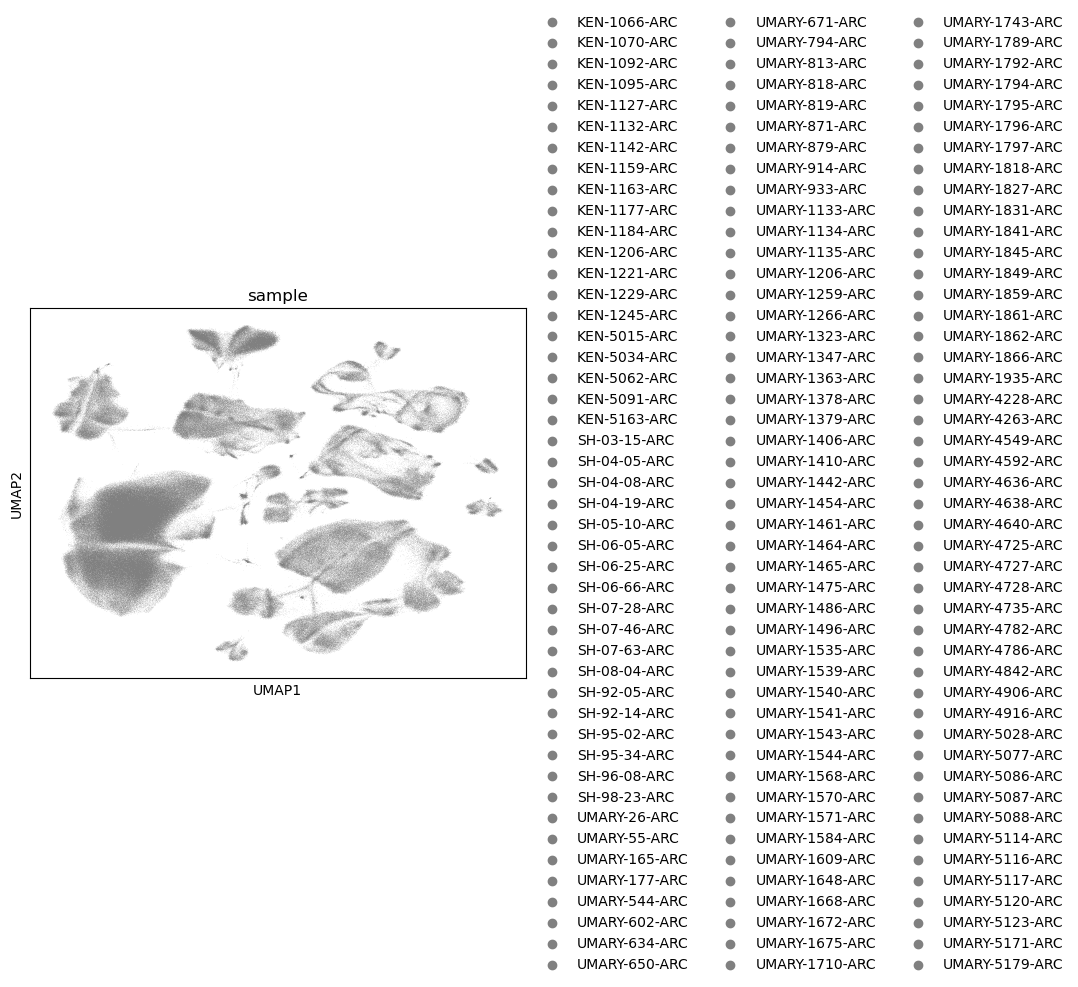

In [35]:
sc.pl.umap(adata, color="sample")


/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


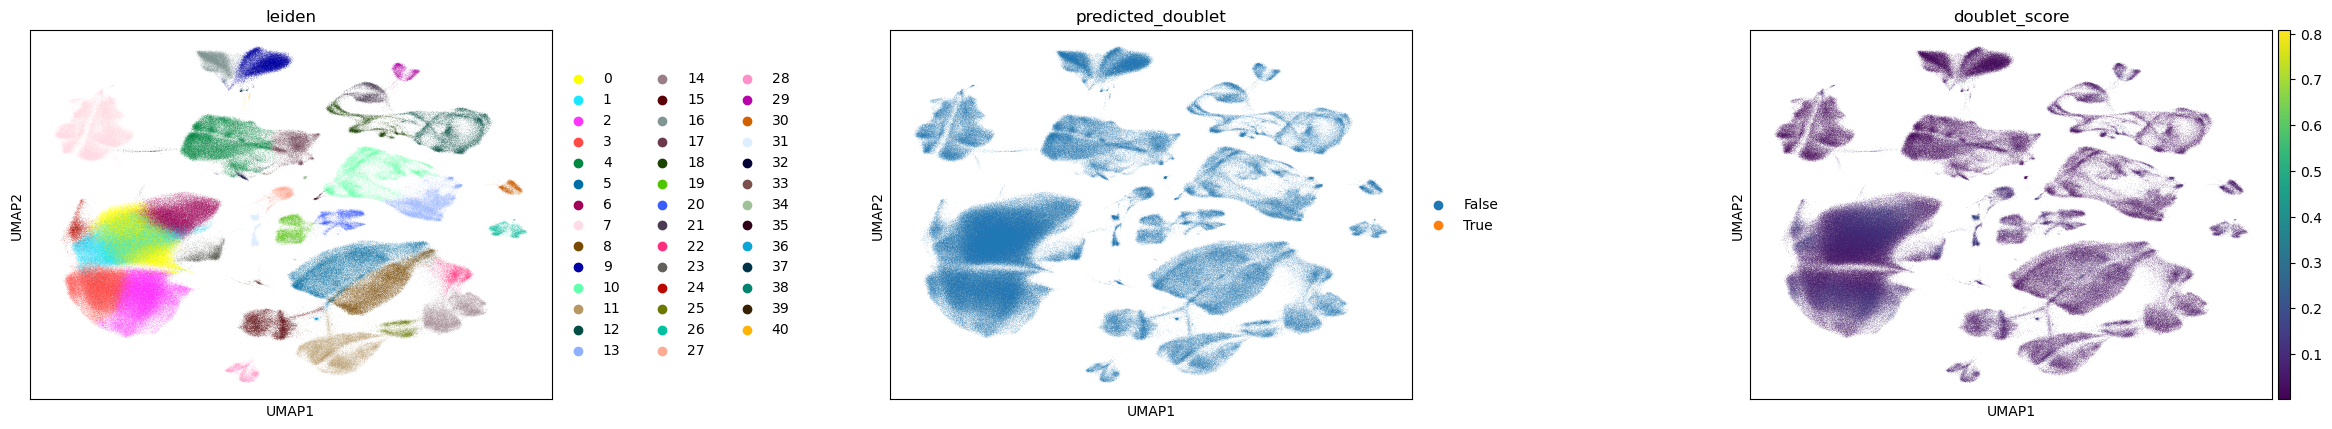

In [36]:

sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
)

/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


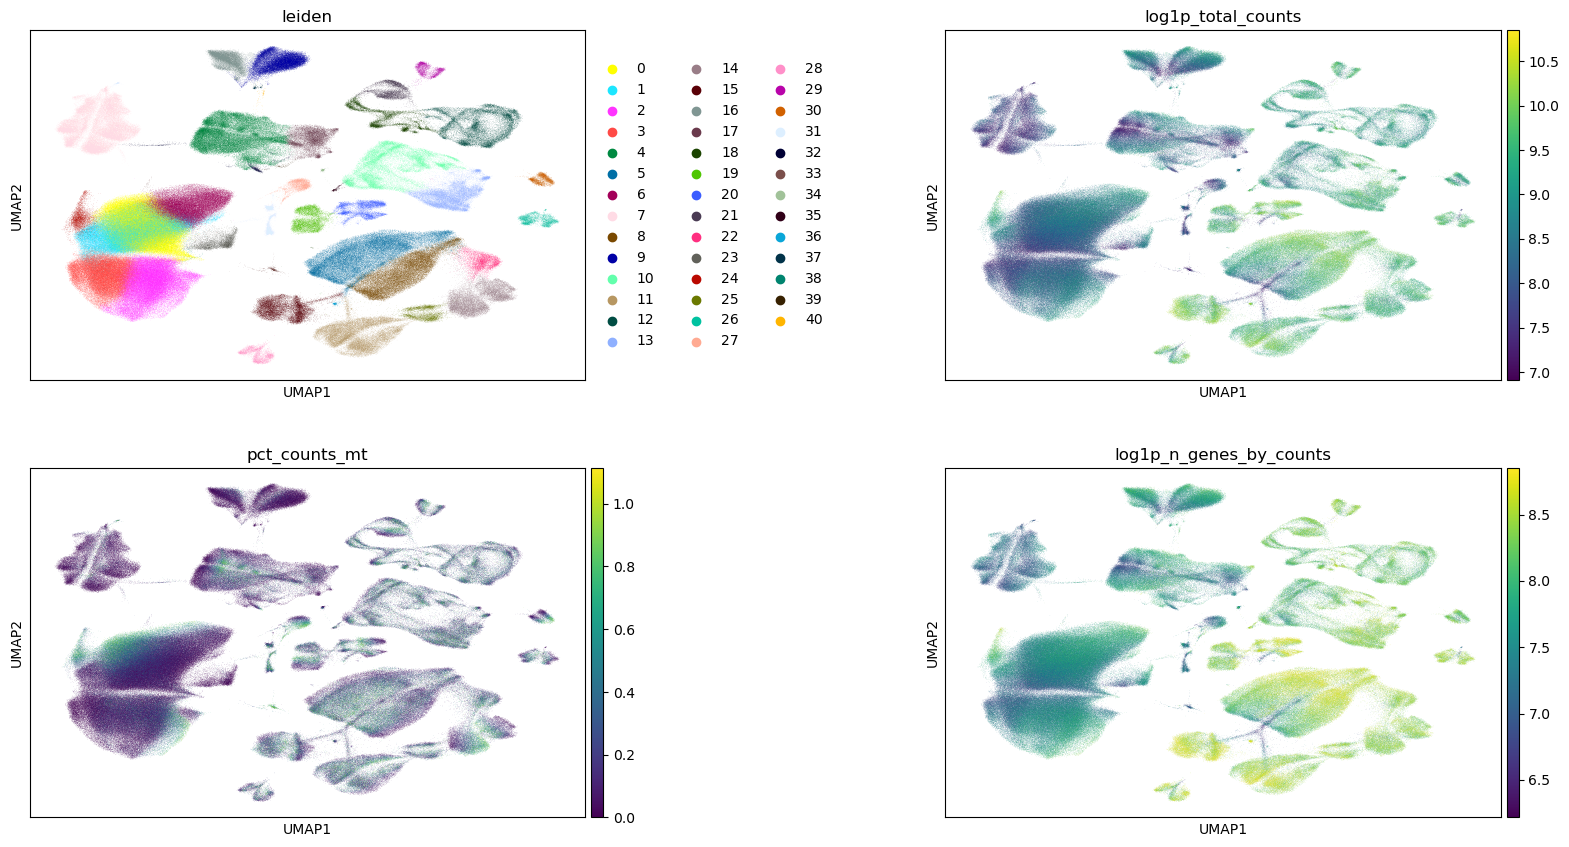

In [37]:
adata_ = adata[adata.obs["predicted_doublet"] == False].copy()
sc.pl.umap(
    adata_, color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"], wspace=0.5, ncols=2
)

/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


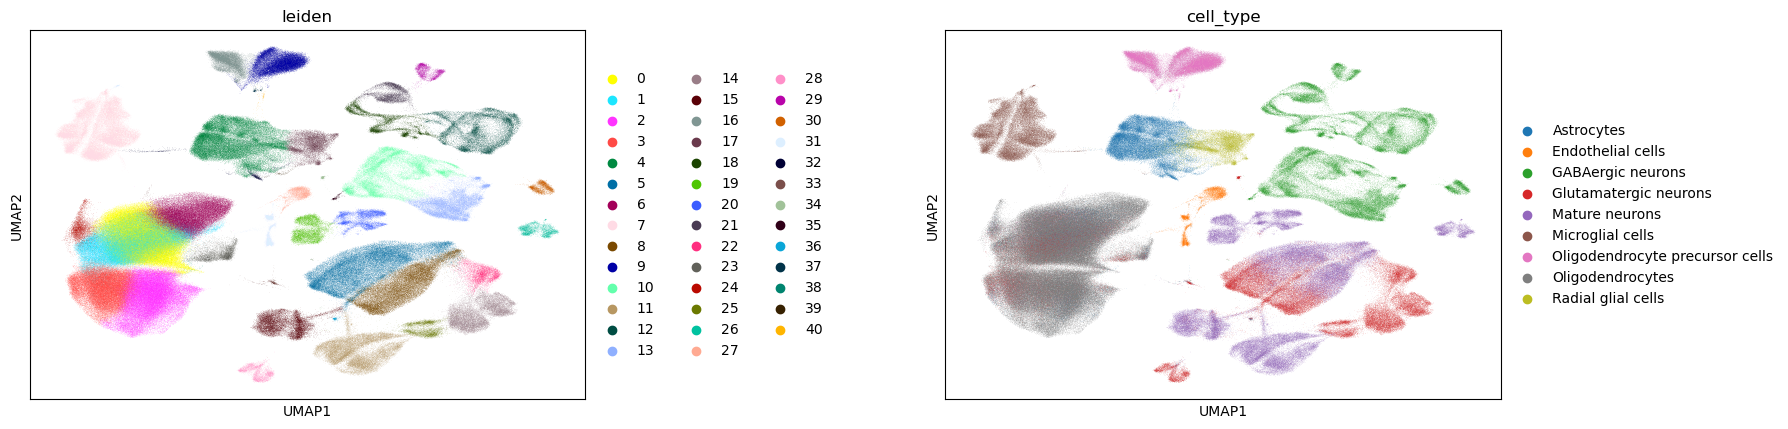

In [38]:
sc.pl.umap(
    adata_, color=["leiden", "cell_type"], wspace=0.5, ncols=2
)

/Users/ergonyc/miniforge3/envs/scverse10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


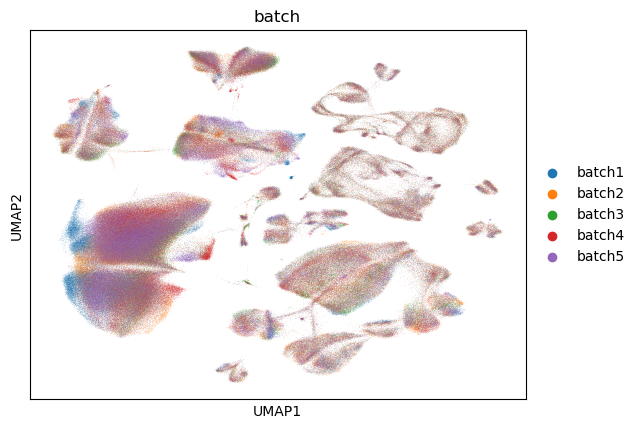

In [52]:
sc.pl.umap(
    adata_, color=["batch"], wspace=0.5, ncols=2
)

In [39]:
adata_

AnnData object with n_obs × n_vars = 713260 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', 'batch', 'leiden'
    var: 'gene_ids', 'big_idx', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'sample_colors', 'predicted_doublet_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    la

In [40]:
adata2 = ad.read_h5ad("/Users/ergonyc/Projects/SingleCell/labelator/data/brain_atlas_anndata.h5ad")
adata2.var_names_make_unique()
features = adata2.var_names.tolist()


In [41]:

del adata2

In [42]:
high_var = adata_.var_names[adata.var.highly_variable].tolist()
adata_.var['high_var'] = [int(x) for x in adata.var.highly_variable ] 

In [43]:
len(high_var)

3000

In [44]:
len(features)

3000

In [45]:
len(set(high_var) - set(features))

1542

In [46]:
len(set(features) - set(high_var) )

1542

In [47]:
adata_.var.highly_variable

PRDM16        True
AL365255.1    True
ERRFI1        True
SLC2A5        True
MIR34AHG      True
              ... 
MT-CO3        True
MT-ND3        True
MT-ND4L       True
MT-ND4        True
MT-CYB        True
Name: highly_variable, Length: 3000, dtype: bool

In [48]:
adata_.var.columns == 'highly_variable'

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False])

In [49]:
adata_

AnnData object with n_obs × n_vars = 713260 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'cell_ids', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', 'batch', 'leiden'
    var: 'gene_ids', 'big_idx', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'high_var'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'sample_colors', 'predicted_doublet_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 

In [50]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


adata_.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_50_genes", 5)
)
adata_.obs.outlier.value_counts()

outlier
False    713260
Name: count, dtype: int64

In [51]:
adata_.write_h5ad("./data/adata_.h5ad")